# LHII Dimers

In [107]:
import re
import glob
import pickle
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 100000)  # or 1000
pd.set_option('display.max_rows', 50)  # or 1000
pd.set_option('display.max_colwidth', 100000)  # or 199

import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({"font.size" : 22})

import read_gaussian

In [120]:
def get_centre(file_name):
    lines = list(open(file_name))
    
    for line in lines:
        if "Mg" in line:
            return 1.88973 * np.array([float(x) for x in re.findall(r'-?\d+.\d+', line)])

def read_exciton_file(file):
    eigenvalues = []
    coupling = None
    distance = None
    
    with open(file) as f:
        lines = f.readlines()    
    
    for enum, line in enumerate(lines):
        if "eigenvalues" in line:
            eigenvalues = [float(x[0]) for x in [re.findall(r'-?\d+.\d+', line) for line in lines[enum+2:enum+5]]]
            
        if "coupling energies" in line:
            coupling = float(re.findall(r'-?\d+.\d+', lines[enum+2])[0])
            
        if "distances" in line:
            distance = float(re.findall(r'-?\d+.\d+', lines[enum+2])[0])
            
    return eigenvalues, coupling, distance
        
def read_bchla_xtb(i, j, frame, file):
    monomerA = f"monomer_xyzs/trunc_bchla_{i}_frame_{frame}.xyz"
    monomerB = f"monomer_xyzs/trunc_bchla_{j}_frame_{frame}.xyz"
    
    centreA = get_centre(monomerA)
    centreB = get_centre(monomerB)
    
    distance = np.linalg.norm(centreA - centreB)
    
    eigenvalues, coupling, charge_centre_distance = read_exciton_file(file)
    
    
    return distance, eigenvalues, coupling, charge_centre_distance

def make_results_df():
    ring_assingments = json.load(open("ring_assignment.json"))
    assign_ring = lambda i : ring_assingments["rings"][f"{i}"]
    
    monomerAs = []
    monomerBs = []
    ringAs = []
    ringBs = []
    frames = []
    
    distances = []
    charge_centre_distances = []
    
    bchla_xtb_states = []
    bchla_xtb_transitions= []
    
    couplings = []

    CAMB3LYP_states = []
    CAMB3LYP_transitions = []
    
    for file in glob.glob("Exciton_Bchla_xTB/*.out"):
        ints = [int(x) for x in re.findall(r'\d+', file)]
        a, b = ints[:-1]
        frame = ints[2]
        
        if frame == 101:
            continue
        
        distance, eigenvalues, coupling, charge_centre_distance = read_bchla_xtb(a, b, frame, file)
        
        try:
            CAMB3LYP_results = read_gaussian.read_gaussian(f"CAMB3LYP/CAMB3LYP_trunc_bchla_{a}_bchla_{b}_frame_{frame}.log")

        except:
            CAMB3LYP_states.append([None, None, None])
            CAMB3LYP_transitions.append([None, None])
        else:
            CAMB3LYP_states.append([CAMB3LYP_results.total_energy, CAMB3LYP_results.state_energies[0], CAMB3LYP_results.state_energies[1]])
            CAMB3LYP_transitions.append(CAMB3LYP_results.excitations[0:2])

        distances.append(distance)
        charge_centre_distances.append(charge_centre_distance)
        
        bchla_xtb_states.append(eigenvalues)
        bchla_xtb_transitions.append([round(x - eigenvalues[0], 6) for x in eigenvalues[1:]])
        couplings.append(abs(coupling))
                
        names.append(f"trunc_bchla_{a}_bchla_{b}_frame_{frame}")
        monomerAs.append(a)
        monomerBs.append(b)
        ringAs.append(assign_ring(a))
        ringBs.append(assign_ring(b))
            
        frames.append(frame)
        
    CAMB3LYP_present = [x[0]!=None for x in CAMB3LYP_states]
        
    return pd.DataFrame.from_dict({
    "monomer A" : np.array(monomerAs),
    "monomer B" : np.array(monomerBs),
    "ring A" : ringAs,
    "ring B" : ringBs,
    "frame" : np.array(frames),
    "distance" : np.array(distances),
    "charge_centre_distance" : np.array(charge_centre_distances),
    "coupling" : couplings,
    "exciton states" : bchla_xtb_states,
    "exciton transitions" : bchla_xtb_transitions,
    "CAMB3LYP states" : CAMB3LYP_states,
    "CAMB3LYP transitions" : CAMB3LYP_transitions,
    "CAMB3LYP present" : CAMB3LYP_present
    })

In [121]:
full_LHII_dimers = make_results_df()

In [122]:
LHII_dimers = full_LHII_dimers.loc[full_LHII_dimers["CAMB3LYP present"]]
LHII_dimers

,monomer A,monomer B,ring A,ring B,frame,distance,charge_centre_distance,coupling,exciton states,exciton transitions,CAMB3LYP states,CAMB3LYP transitions,CAMB3LYP present
37,20,21,B800,B850b,1,36.210442,34.0634,8.2531,"[-253.1781, -253.1114, -253.111]","[0.0667, 0.0671]","[-4069.82252346, -4069.7595241288373, -4069.754052157531]","[0.06299933116267446, 0.06847130246881822]",True
45,3,21,B850b,B850b,1,89.111401,86.8109,0.0721,"[-253.2235, -253.1564, -253.1557]","[0.0671, 0.0678]","[-4069.86207247, -4069.799080488698, -4069.798499849701]","[0.06299198130195433, 0.06357262029884533]",True
48,8,15,B800,B850b,1,69.838250,66.8723,5.1479,"[-253.2201, -253.1526, -253.1513]","[0.0675, 0.0688]","[-4069.80987645, -4069.7465316753837, -4069.7461568324866]","[0.06334477461652102, 0.06371961751324812]",True
60,10,20,B850a,B800,1,114.692638,113.2124,0.9788,"[-253.23, -253.1631, -253.1615]","[0.0669, 0.0685]","[-4069.8028227, -4069.7378352315127, -4069.734277898924]","[0.06498746848747215, 0.06854480107601961]",True
64,6,13,B850b,B850a,1,75.752043,75.9496,0.4332,"[-253.2497, -253.1839, -253.1835]","[0.0658, 0.0662]","[-4069.81498151, -4069.753202255717, -4069.751772707807]","[0.06177925428313134, 0.06320880219319844]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3491,10,15,B850a,B850b,1,51.210960,49.2519,15.1123,"[-253.2466, -253.1791, -253.1781]","[0.0675, 0.0685]","[-4069.7982117, -4069.7344994323475, -4069.733238931234]","[0.06371226765252798, 0.06497276876603188]",True
3498,6,26,B850b,B800,1,69.737211,66.8155,6.5399,"[-253.1772, -253.111, -253.1097]","[0.0662, 0.0675]","[-4069.79895381, -4069.735836881066, -4069.735719283294]","[0.0631169289341967, 0.06323452670571893]",True
3500,8,20,B800,B800,1,125.839329,122.5928,0.6289,"[-253.2035, -253.1366, -253.1347]","[0.0669, 0.0688]","[-4069.81446787, -4069.7511230953837, -4069.745923068924]","[0.06334477461652102, 0.06854480107601961]",True
3504,3,14,B850b,B800,1,115.568390,112.0170,0.7491,"[-253.2166, -253.151, -253.1487]","[0.0656, 0.0679]","[-4069.82455908, -4069.7628055502296, -4069.760986459701]","[0.06175352977061084, 0.06357262029884533]",True


In [163]:
def get_values(series, i):
    return [x[i] for x in series]

def assign_transitions(df):
    #this is probably wrong
    
    camb3lyp_transitions = [get_values(LHII_dimers["CAMB3LYP transitions"], 0), get_values(LHII_dimers["CAMB3LYP transitions"], 1)]
    exciton_transitions  = [get_values(LHII_dimers["exciton transitions"], 0), get_values(LHII_dimers["exciton transitions"], 1)]
    
    distances = LHII_dimers["distance"].to_numpy()
    
    assigned_camb3lyp_transitions = []
    assigned_exciton_transitions = []
    all_distances = []
    
    for enum, trns in enumerate(camb3lyp_transitions[0]):
        
        same_index = abs(camb3lyp_transitions[0][enum] - exciton_transitions[0][enum]) + abs(camb3lyp_transitions[0][enum] - exciton_transitions[0][enum])
        opps_index = abs(camb3lyp_transitions[1][enum] - exciton_transitions[0][enum]) + abs(camb3lyp_transitions[0][enum] - exciton_transitions[1][enum])
        
        if(same_index < opps_index):
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[0][enum])
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[1][enum])
            
            assigned_exciton_transitions.append(exciton_transitions[0][enum])
            assigned_exciton_transitions.append(exciton_transitions[1][enum])
            
        elif(opps_index < same_index):
            print(round(camb3lyp_transitions[0][enum], 4), round(camb3lyp_transitions[1][enum], 4))
            print(exciton_transitions[0][enum], exciton_transitions[1][enum])
            print()
            
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[0][enum])
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[1][enum])
            
            assigned_exciton_transitions.append(exciton_transitions[1][enum])
            assigned_exciton_transitions.append(exciton_transitions[0][enum])
        
        all_distances.append(distances[enum])
        all_distances.append(distances[enum])
        
    assert(len(assigned_camb3lyp_transitions) == len(assigned_exciton_transitions))
    assert(len(assigned_camb3lyp_transitions) == len(all_distances))
    
    return assigned_camb3lyp_transitions, assigned_exciton_transitions, all_distances

## By Distance

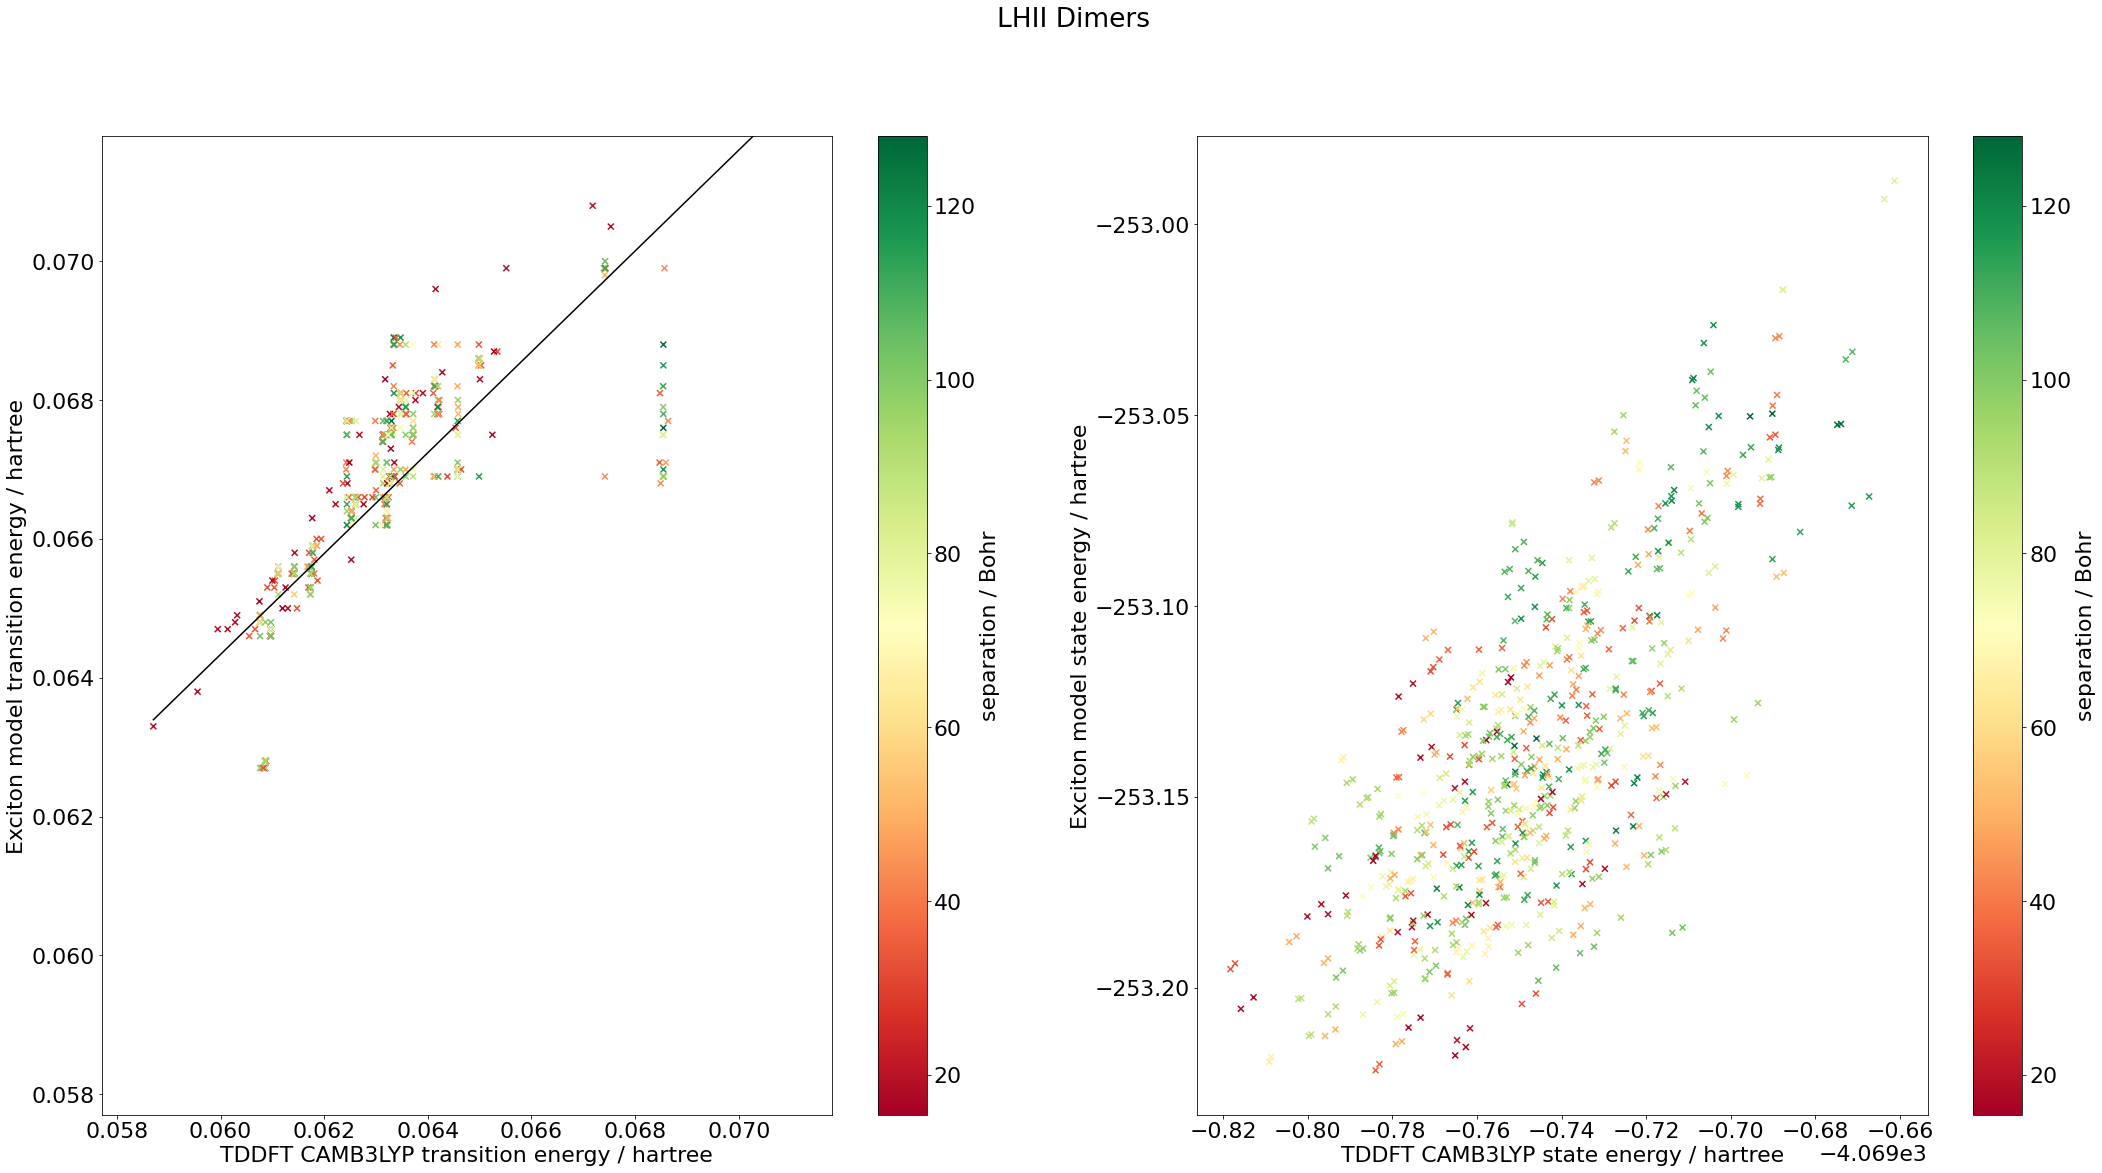

In [181]:
fig, ax = plt.subplots(1, 2)

camb3lyp_transitions = np.concatenate((get_values(LHII_dimers["CAMB3LYP transitions"], 0), get_values(LHII_dimers["CAMB3LYP transitions"], 1)))
exciton_transitions  = np.concatenate((get_values(LHII_dimers["exciton transitions"], 0), get_values(LHII_dimers["exciton transitions"], 1)))

camb3lyp_states = np.concatenate((get_values(LHII_dimers["CAMB3LYP states"], 1), get_values(LHII_dimers["CAMB3LYP states"], 2)))
exciton_states  = np.concatenate((get_values(LHII_dimers["exciton states"], 1), get_values(LHII_dimers["exciton states"], 2)))

all_distances = np.concatenate((LHII_dimers["distance"], LHII_dimers["distance"]))

cax_transition = ax[0].scatter(camb3lyp_transitions, exciton_transitions,  c=all_distances, cmap='RdYlGn', marker='x')
cax_states = ax[1].scatter(camb3lyp_states, exciton_states,  c=all_distances, cmap='RdYlGn', marker='x')

max_transition = max(max(camb3lyp_transitions), max(exciton_transitions))
min_transition = min(min(camb3lyp_transitions), min(exciton_transitions))
padding = 0.001

p = np.polyfit(camb3lyp_transitions, exciton_transitions, deg=1)

line_of_best_fit = lambda x : p[0] * x + p[1]

ax[0].plot([min_transition, max_transition], [line_of_best_fit(x) for x in [min_transition-padding, max_transition+padding]], color='black')

ax[0].set_xlim(min_transition - padding, max_transition + padding)
ax[0].set_ylim(min_transition - padding, max_transition + padding)

ax[0].set_xlabel("TDDFT CAMB3LYP transition energy / hartree")
ax[0].set_ylabel("Exciton model transition energy / hartree")

ax[1].set_xlabel("TDDFT CAMB3LYP state energy / hartree")
ax[1].set_ylabel("Exciton model state energy / hartree")

cbar_transition = fig.colorbar(cax_transition, ax=ax[0])
cbar_transition.set_label("separation / Bohr")

cbar_states = fig.colorbar(cax_states, ax=ax[1])
cbar_states.set_label("separation / Bohr")

fig.suptitle("LHII Dimers")

fig.set_size_inches(36, 18)

## Ring interactions

In [187]:
def split_by_rings(df):
    B800_B800 = df.loc[(df["ring A"] == "B800") & (df["ring B"] == "B800")]

    B850_B850 = df.loc[(df["ring A"].isin(["B850a", "B850b"])) & (df["ring B"].isin(["B850a", "B850b"]))]

    B850_B800 = df.loc[(df["ring A"].isin(["B850a", "B850b"])) & (df["ring B"].isin(["B800"]))]
    B800_B850 = df.loc[(df["ring A"].isin(["B800"])) & (df["ring B"].isin(["B850a", "B850b"]))]
    
    return B800_B800, B850_B850, pd.concat([B850_B800, B800_B850])

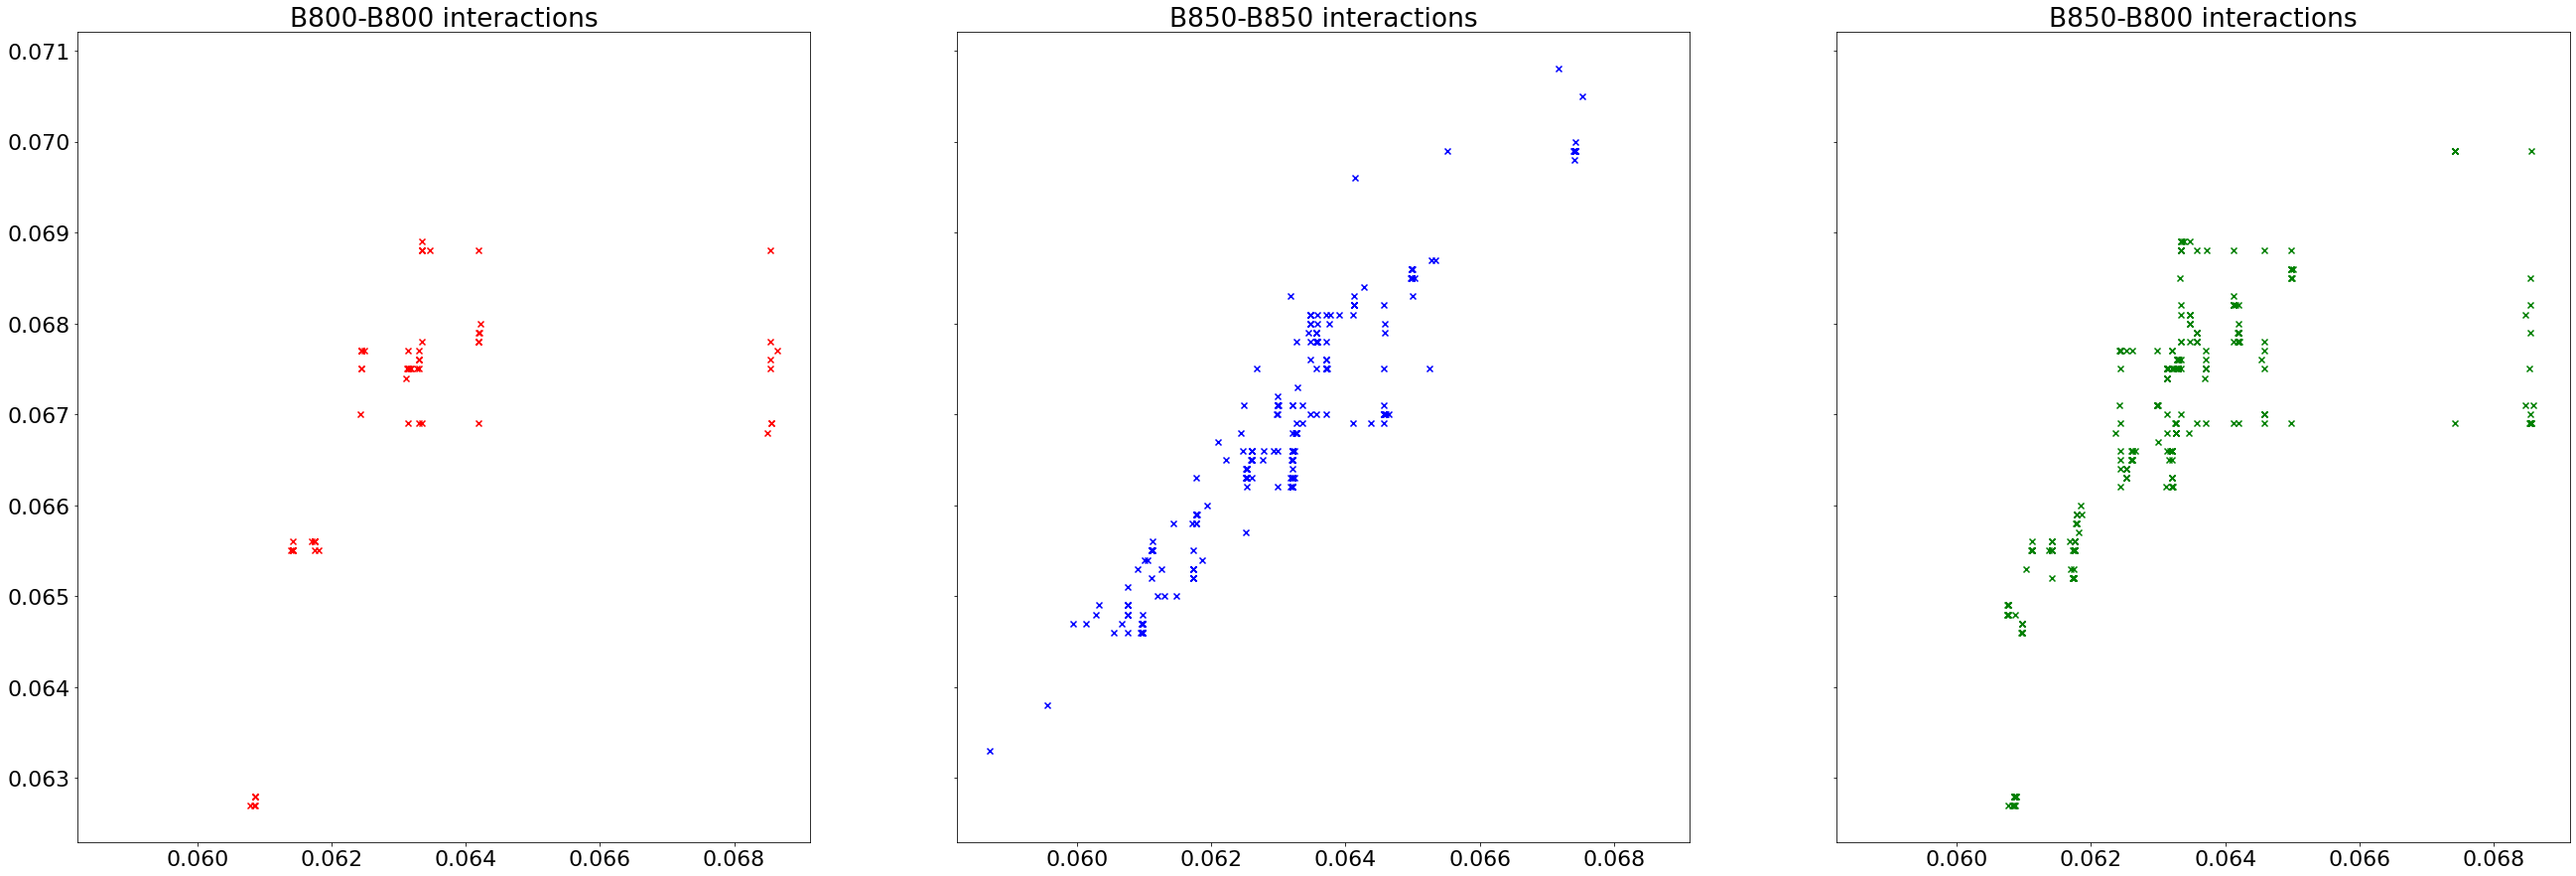

In [194]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)

B800_B800, B850_B850, B850_B800 = split_by_rings(LHII_dimers)

B800_B800_camb3lyp = np.concatenate((get_values(B800_B800["CAMB3LYP transitions"], 0), get_values(B800_B800["CAMB3LYP transitions"], 1)))
B800_B800_excitons = np.concatenate((get_values(B800_B800["exciton transitions"], 0), get_values(B800_B800["exciton transitions"], 1)))

B850_B850_camb3lyp = np.concatenate((get_values(B850_B850["CAMB3LYP transitions"], 0), get_values(B850_B850["CAMB3LYP transitions"], 1)))
B850_B850_excitons = np.concatenate((get_values(B850_B850["exciton transitions"], 0), get_values(B850_B850["exciton transitions"], 1)))

B850_B800_camb3lyp = np.concatenate((get_values(B850_B800["CAMB3LYP transitions"], 0), get_values(B850_B800["CAMB3LYP transitions"], 1)))
B850_B800_excitons = np.concatenate((get_values(B850_B800["exciton transitions"], 0), get_values(B850_B800["exciton transitions"], 1)))

ax[0].scatter(B800_B800_camb3lyp, B800_B800_excitons, marker='x', color='red')
ax[1].scatter(B850_B850_camb3lyp, B850_B850_excitons, marker='x', color='blue')
ax[2].scatter(B850_B800_camb3lyp, B850_B800_excitons, marker='x', color='green')

ax[0].set_title("B800-B800 interactions")
ax[1].set_title("B850-B850 interactions")
ax[2].set_title("B850-B800 interactions")

fig.set_size_inches(45, 15)

# Exciton coupling

In [182]:
full_LHII_dimers

,monomer A,monomer B,ring A,ring B,frame,distance,charge_centre_distance,coupling,exciton states,exciton transitions,CAMB3LYP states,CAMB3LYP transitions,CAMB3LYP present
0,23,26,B800,B800,30001,42.160708,40.8740,40.6102,"[-253.1937, -253.1267, -253.1257]","[0.067, 0.068]","[None, None, None]","[None, None]",False
1,1,7,B850a,B850a,15001,61.398402,61.8578,7.8413,"[-253.2166, -253.1481, -253.1475]","[0.0685, 0.0691]","[None, None, None]","[None, None]",False
2,14,23,B800,B800,35001,112.332878,109.4119,1.2062,"[-253.1818, -253.1148, -253.1142]","[0.067, 0.0676]","[None, None, None]","[None, None]",False
3,14,26,B800,B800,30001,129.257554,125.8391,0.7325,"[-253.2009, -253.1336, -253.1331]","[0.0673, 0.0678]","[None, None, None]","[None, None]",False
4,1,2,B850a,B800,10001,48.614758,46.2191,11.6444,"[-253.1924, -253.1254, -253.1246]","[0.067, 0.0678]","[None, None, None]","[None, None]",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,8,11,B800,B800,35001,41.551672,41.3555,35.0473,"[-253.1489, -253.0819, -253.0807]","[0.067, 0.0682]","[None, None, None]","[None, None]",False
3506,4,26,B850a,B800,30001,53.738334,51.8703,4.4676,"[-253.2081, -253.1423, -253.1403]","[0.0658, 0.0678]","[None, None, None]","[None, None]",False
3507,10,23,B850a,B800,30001,117.274032,115.7739,0.9125,"[-253.2224, -253.1557, -253.1553]","[0.0667, 0.0671]","[None, None, None]","[None, None]",False
3508,15,27,B850b,B850b,1,99.423275,97.3172,0.2866,"[-253.2327, -253.1663, -253.1652]","[0.0664, 0.0675]","[-4069.83662737, -4069.7741021048537, -4069.772911427417]","[0.06252526514622547, 0.06371594258288805]",True


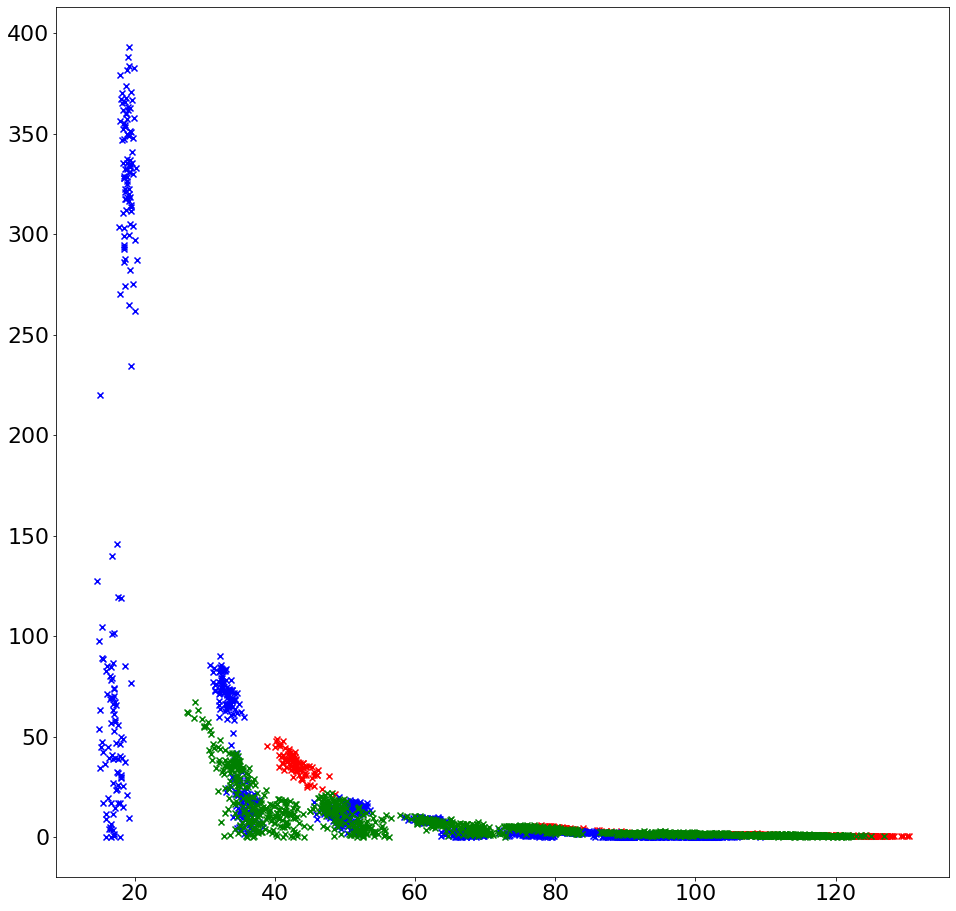

In [196]:
fig, ax = plt.subplots()

B800_B800, B850_B850, B850_B800 = split_by_rings(full_LHII_dimers)

ax.scatter(B800_B800["distance"], B800_B800["coupling"], marker='x', color='red')
ax.scatter(B850_B850["distance"], B850_B850["coupling"], marker='x', color='blue')
ax.scatter(B850_B800["distance"], B850_B800["coupling"], marker='x', color='green')

fig.set_size_inches(16, 16)

In [198]:
for i in range(1, 28):
    for j in range(i+1, 28):
        CAMB3LYP_results = read_gaussian.read_gaussian(f"CAMB3LYP/CAMB3LYP_trunc_bchla_{i}_bchla_{j}_frame_1.log")
        
        print(CAMB3LYP_results.excitations)

[0.06172780525809036, 0.06420470832077732, 0.08057652307488773, 0.082226566806559, 0.11128791609399002]
[0.05994546403345656, 0.06414958436537628, 0.07677664508257569, 0.07992238547079532, 0.08258670998184585]
[0.06055182754286806, 0.06187112754213307, 0.0805801980052478, 0.08275575677840905, 0.10074454089095011]
[0.06173148018845043, 0.06330067545220018, 0.08057652307488773, 0.08238458881204201, 0.1148636233343378]
[0.06172780525809036, 0.06323452670571893, 0.08057284814452766, 0.08123801053970027, 0.10912338211190897]
[0.06173148018845043, 0.0645942509389447, 0.08057652307488773, 0.0815981537149871, 0.11315110578654534]
[0.061735155118810496, 0.06334477461652102, 0.08057284814452766, 0.08389866012039071, 0.11589627876551739]
[0.061735155118810496, 0.06320512726283836, 0.08049934953732626, 0.08057284814452766, 0.11178403169259941]
[0.061735155118810496, 0.06498746848747215, 0.08057652307488773, 0.08363039020410563, 0.11043533225045385]
[0.060864196623473976, 0.061735155118810496, 0.08